![book header](pictures/header.png)

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import csv
# from serial import Serial # Uncomment this line if you are using the real car
from KITT_Simulator.serial_simulator import Serial # Uncomment this line if you are using the simulator

# Module 2 - Reading KITT Sensor Data

KITT relies on its sensors to drive autonomously. It is equipped with:
1. Two front-mounted distance sensors.
2. Five microphones positioned around the field to record audio signals from KITT's beacon and relay them to the soundcard after which they can be read by your PC.

This task focuses on reading data from the distance sensors to avoid obstacles and processing the microphone data from the field.

**Preparation**
- Ensure KITT is operational and properly set up.
- Reserve time for testing on a field equipped with microphones and an audio card.
- For Windows 10 users, install ASIO4ALL and use a PyAudio build compatible with ASIO.
- For Mac users, install PyAudio using Homebrew.
 
 ---

## 1. Distance Sensors

KITT’s front distance sensors use ultrasonic technology. Two SRF02 modules, mounted on the left and right sides, measure the distance to obstacles. These sensors work by emitting a 40 kHz pulse and measuring the time it takes for the echo to return. This time is converted into a distance measurement.

- Each sensor requires a minimum of 66 ms between readings, as specified in the SRF02 datasheet (available at: Files/Datasheets/srf02.pdf).
- The system is configured with a 70 ms cycle time, during which the left and right sensors take turns recording measurements.
- These measurements are stored in a buffer on KITT's microcontroller, with each new reading overwriting the previous one.

<img src="pictures/srf02-ultrasonic-sensor.jpg" alt="Ultrasonic Sensor" width="400" height="240">

To ensure you can experiment at home, we have added the status command to the simulator. The simulator will accurately simulate the sensor distances, but not its behavior. Make sure to test on the real car frequently.

### Step 1: Status Command

You can ask KITT to capture a status command by writing "S\n" to the serial port. Then you have to read the message using "read_until", this will generate a binary message that you need to decode. KITT always ends it's message with the end-of-transmission character (0x04). The response contains 3 sections. 
1) Audio Beacon status and settings
2) PWM values for the motors
3) Sensor readings

In [4]:
serial = Serial('/dev/ttyUSB0', 115200)
time.sleep(0.1) # Wait for the serial to open
serial.write(b'S\n')
status = serial.read_until(b'\x04').decode('utf-8')
print(status)
serial.close()

Canvas(height=520, width=520)

**************************
* Audio Beacon: off
* c: 0xabcdef00
* f_c: 5678
* f_b: 1234
* c_r: 1337
**************************
* PWM:
* Dir. 150
* Mot. 150
**************************
* Sensors:
* Dist. L 420.0 R 420.0
* V_batt 11.5 V
**************************



### Isolating Specific Data from KITT

If you only need specific information, such as the distance measurements, battery voltage, or version information, you can request them separately:

- **For distance measurements only**: Use the command:
  ```python
  serial_port.write(b'Sd\n')
  ```
  This returns only the left and right distance sensor values, filtering out the rest of the status report.

- **For battery voltage**: Use the command:
  ```python
  serial_port.write(b'Sv\n')
  ```
  This command returns just the battery voltage level.

- **For version information**: Use the command:
  ```python
  serial_port.write(b'V\n')
  ```
  This sends back the version details of KITT’s firmware.

### Step 2: Extracting and Isolating Distance Data

Once you have received the status information from KITT, you can extract and isolate the distance sensor readings (left and right) from the full status report.

#### Code to Extract Distance Data:

After sending the status command (`b'S\n'`), the response will contain a variety of information, including the distance measurements. Now write a Python function to extract the distance data from the status report.

1. **Send the Status Command** to receive the full status report:

In [6]:
serial = Serial('/dev/ttyUSB0', 115200)
time.sleep(0.1)
serial.write(b'S\n')
status = serial.read_until(b'\x04')
serial.close()

Canvas(height=520, width=520)

2. **Extract the Distance Measurements**:
   The distance values are typically embedded in the `Sensors` section of the status response. You can process the `status` output to isolate just the left (`L`) and right (`R`) distance sensor values . Write a function to extract these values.

In [7]:
# Convert the status response to a string
status_str = status.decode('utf-8')

# Find the line with the distance sensor data
for line in status_str.splitlines():
    if "Dist." in line:
        # Extract the left and right distance values
        _, _, _, dist_L, _, dist_R = line.split()
        print(f"Left Distance: {dist_L}")
        print(f"Right Distance: {dist_R}")

Left Distance: 420.0
Right Distance: 420.0


### Step 3: Using Distance Values to Model the Car

Ultrasonic sensors are not just for detecting obstacles; they play a crucial role in modeling the car's behavior during autonomous driving. To control the car effectively, we need to understand how it responds to drive and steering commands, similar to how a human driver knows how much acceleration or steering input affects the car's movement.

However, while KITT doesn’t have an accelerometer to measure acceleration directly, we can use the ultrasonic sensors to estimate how the car moves over time. By measuring the distance to cardboard-box wall, we can derive its speed and acceleration.

#### Understanding Speed and Acceleration

- **Velocity** is the rate of change of position over time:
  $$
  \text{Velocity} = \frac{\Delta x}{\Delta t}
  $$

- **Acceleration** is the change in speed over time:
  $$
  \text{Acceleration} = \frac{\Delta v}{\Delta t}
  $$

#### Plotting KITT's Motion Towards a Wall

To understand how KITT moves, make recordings of the distance sensor values as KITT drives towards a wall. Do this for multiple motor commands, and store them in a .csv file. (You can use the Files/Recordings folder to organise your data). You can then plot the distance values over time to visualize KITT's motion. Also make plots of the speed and acceleration of KITT.

#### Avoiding Crashes

For this, KITT drives towards a wall at a constant speed. Please, place KITT infront of the supplied cardboard wall. Turn of KITT's motors after the distance is less than 40cm to ensure KITT does not crash too hard. Make sure to discard the first few readings as they may be inaccurate.

In [8]:
# Open a serial connection to KITT
serial_port = Serial('/dev/ttyUSB0', 115200)

# Define the motor command (constant speed)
motor_command = b'M160\n'  # Example speed command
serial_port.write(motor_command)

# List to store recorded data
data = []

# Record data for 10 seconds
start_time = time.time()
while time.time() - start_time < 10:
    # Send the command to get the distance readings
    serial_port.write(b'S\n')
    
    # Read the distance values from KITT
    status = serial_port.read_until(b'\x04').decode('utf-8')
    
    # Extract the distance values (assuming format "Dist. L xxx R xxx")
    for line in status.splitlines():
        if "Dist." in line:
            _, _, _, dist_L, _, dist_R = line.split()
            # Record current time, left and right distances
            current_time = time.time() - start_time
            data.append([current_time, float(dist_L), float(dist_R)])

    if float(dist_L) < 40 or float(dist_R) < 40:
        serial_port.write(b'M150\n')
    
    time.sleep(0.1)  # Wait a bit before next reading

# Close the serial connection
serial_port.close()

# Write data to a CSV file
with open(f'Files/Recordings/kitt_distance_data_{motor_command[1:-1].decode()}.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Time', 'Distance_L', 'Distance_R'])
    writer.writerows(data)

print(f"Data recording completed and saved to 'kitt_distance_data_{motor_command[1:-1].decode()}.csv'.")

Canvas(height=520, width=520)

Car is outside the field boundaries!
Data recording completed and saved to 'kitt_distance_data_160.csv'.


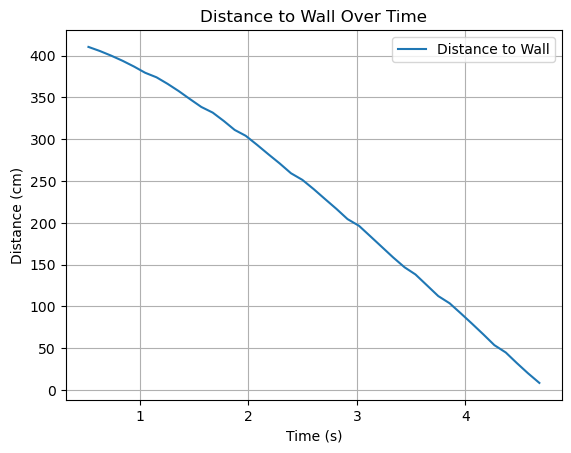

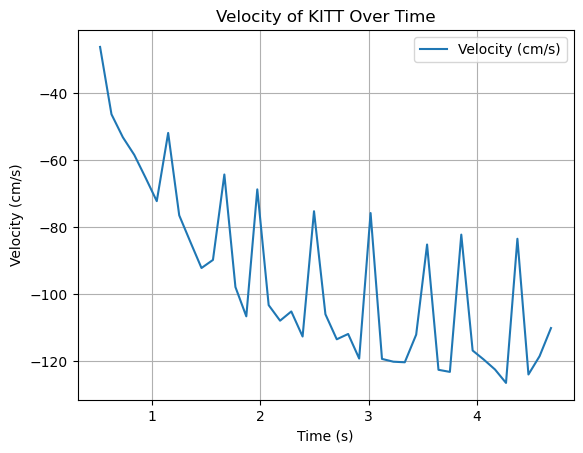

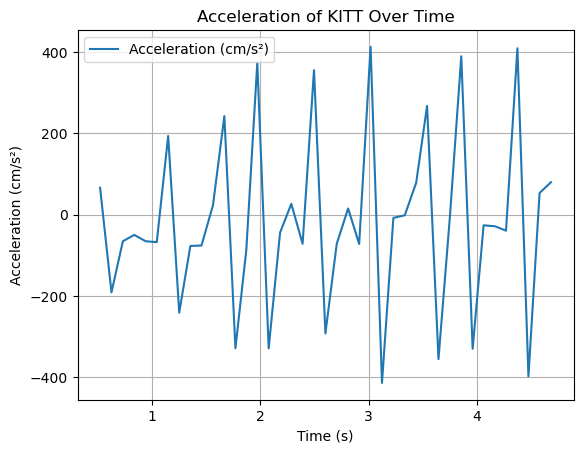

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

motor_command = b'M160\n'  # Example speed command

# Load the recorded data from the CSV file
data = pd.read_csv(f'Files/Recordings/kitt_distance_data_{motor_command[1:-1].decode()}.csv')

# Calculate average distance (left and right sensors)
data['Distance_Avg'] = (data['Distance_L'] + data['Distance_R']) / 2

# Calculate velocity (change in distance over time)
data['Velocity'] = data['Distance_Avg'].diff() / data['Time'].diff()

# Calculate acceleration (change in velocity over time)
data['Acceleration'] = data['Velocity'].diff() / data['Time'].diff()

# Discard the first few readings (inaccurate readings)
data = data.iloc[5:]

# Plotting Distance
plt.figure()
plt.plot(data['Time'], data['Distance_Avg'], label='Distance to Wall')
plt.xlabel('Time (s)')
plt.ylabel('Distance (cm)')
plt.title('Distance to Wall Over Time')
plt.grid(True)
plt.legend()
plt.show()

# Plotting Velocity
plt.figure()
plt.plot(data['Time'], data['Velocity'], label='Velocity (cm/s)')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (cm/s)')
plt.title('Velocity of KITT Over Time')
plt.grid(True)
plt.legend()
plt.show()

# Plotting Acceleration
plt.figure()
plt.plot(data['Time'], data['Acceleration'], label='Acceleration (cm/s²)')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (cm/s²)')
plt.title('Acceleration of KITT Over Time')
plt.grid(True)
plt.legend()
plt.show()

### Step 4: Characteristics of the Distance Sensors
Write your own code and report on the following questions:
1. What is the accuracy of the distance sensors? How does it change with distance?
2. What are the minimum and maximum distances the sensors can measure?
3. What is the time resolution of the distance sensors? How old is a measurement by the time you receive it? What happens when you try to read the sensors too quickly?
4. What is the field of view of the distance sensors (beam angle)? How does it affect the measurements?
4. How do the distance sensors behave when KITT is moving towards a wall? What could you do to improve the resolution of the distance sensor readings? Is one of the sensors more accurate than the other?
5. How do the distance sensors behave when KITT is moving away from a wall? 

Note: Do not copy the questions into your report, but include the information in your report.

Tip to consider:

**Continuous Measurement** involves data that can be taken at any point in time, with no gaps. For example, a car’s speedometer provides a continuous record of the car’s speed. 

**Discrete Measurement**, on the other hand, collects data at specific intervals. For instance, KITT’s ultrasonic sensors take distance readings every 70 ms. In between these measurements, we don’t know the exact position of the car. Discrete data can still be useful, but it may miss details about rapid changes in speed or acceleration that occur between measurements. In order to interprete it correctly, you may need to filer or interpolate the data.

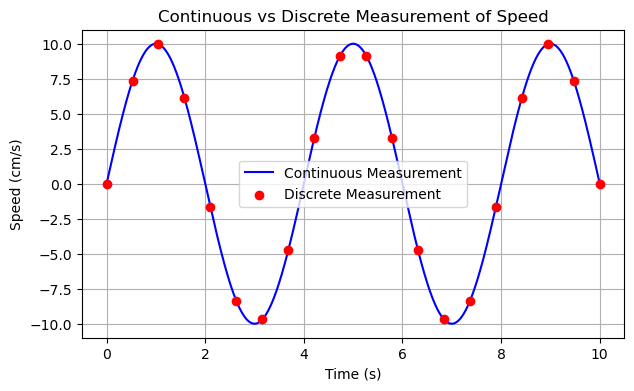

In [10]:
# Define time for continuous measurement (smooth, no gaps)
time_continuous = np.linspace(0, 10, 1000)  # Time from 0 to 10 seconds, 1000 data points
# Define time for discrete measurement (specific intervals)
time_discrete = np.linspace(0, 10, 20)  # Time from 0 to 10 seconds, 20 data points
# Simulate continuous speed (sinusoidal speed pattern for illustration)
speed_continuous = 10 * np.sin(0.5 * np.pi * time_continuous)  # Continuous speed
# Simulate discrete speed (sampled at specific intervals)
speed_discrete = 10 * np.sin(0.5 * np.pi * time_discrete)  # Discrete speed
# Plotting both continuous and discrete measurements
plt.figure(figsize=(7, 4))
# Plot continuous data
plt.plot(time_continuous, speed_continuous, label="Continuous Measurement", color="blue")
# Plot discrete data
plt.scatter(time_discrete, speed_discrete, label="Discrete Measurement", color="red", zorder=5)
# Add labels and title
plt.xlabel('Time (s)')
plt.ylabel('Speed (cm/s)')
plt.title('Continuous vs Discrete Measurement of Speed')
plt.legend()
plt.grid(True)
plt.show()

### Step 5: Implementing the distance sensor reading in your KITT class
In the previous module, you have created a class for KITT. Add a method to read the distance sensors to your class. You can use the code you have written in the previous steps to do this. Make sure to test your code. It is advisable to store all the old distance data in a list inside the KITT class. This will be convenient during the final challenge, where the route planning might need old measurements to determine the position of objects.

### Step 6: Mid-term assessment 2.1 and report

After you finish this assignment, and ultimo in week 4, showcase the functionality of your script to your assigned TA. After you pass this assessment, you are ready to document your results in your midterm report. For this Module, you would include a chapter that covers the above tasks (using independently-readable text, i.e., don’t refer to “Task 1”). Include plots; for each plot it should be clear how the plot was made (i.e., the corresponding experimental set-up), and you have to describe what is seen in the plot before you discuss results and derive conclusions. Review the guidelines for more information. Include the corresponding code in an Appendix. Remember to document your code, using comments to define input/output variables of functions and to explain the logic and any modifications made. Your completed script will be crucial for the upcoming challenges, contributing to the overall autonomous driving system.

---
## The Microphones

Four microphones of the field are installed around its corners, and a fifth microphone is placed between two of the microphones at the edge of the field, at a level higher than the other four. These microphones, along with the beacon atop KITT, will be used to locate KITT within the field (chapter 5 ??@B update).

The appropriate sound card driver must be used to use the microphone array. The soundcard used in EPO-4 is a PreSonus AudioBox 1818VSL. On Linux, OSX (except the ARM version), and Windows 11, the sound card works out of the box. On Windows 10, it is necessary to install [ASIO4ALL](https://www.asio4all.org/) and a build of [PyAudio](https://www.lfd.uci.edu/~gohlke/pythonlibs/#pyaudio) compiled with ASIO support. If you use the Pipfile provided on Brightspace, the correct version of PyAudio should already be installed, but you still need to install ASIO4ALL manually.

A typical laptop will have many possible audio devices, for example the built-in microphone, a Bluetooth headset, and the AudioBox 1818VSL used in EPO-4. To initialize the microphone array, the correct audio device should be specified. This short script will list the index and names of all audio devices visible to PyAudio.

In [ ]:
# (??@B change this to a better location)
%pip install -r requirements.txt
%pip install keyboard
%pip install pyaudio # @Mano @Mehrdad version

In [ ]:
import matplotlib
import numpy
import serial
import keyboard
import scipy
import statsmodels
import ipywidgets
import pyaudio
import tkinter as tk

In [ ]:

import pyaudio
pyaudio_handle = pyaudio.PyAudio()
for i in range(pyaudio_handle.get_device_count()):
    device_info = pyaudio_handle.get_device_info_by_index(i)
    print(i, device_info['name'])



```{important} Click to Show

On Windows 10, make sure to use the audio device index that has ASIO in the name. Other audio devices may be using the legacy MME or WDM Windows drivers, which may not support more than 2 synchronous
audio channels.

```

The microphone array must first be initialized. When doing so, the sampling frequency that will be used must be specified. This sampling frequency will either be 48 kHz or 44.1 kHz, depending on the type of audio device ( This should be more clear). Initializing the microphone array at device index `device_index` with a sampling frequency of `Fs` is done as, 


In [ ]:
# From the list of devices, add the desired index and the appropriate Fs value for the same.

stream = pyaudio_handle.open(input_device_index=device_index,
                            channels=5,
                            format=pyaudio.paInt16,
                            rate=Fs,
                            input=True)


To make a recording, the length of the recording must be specified. This must be specified as the number of audio frames to be recorded. The result will be a *bytes* object. Each audio frame will contain 5 samples, one for each microphone. Each sample contains 2 bytes, since we specified 16-bit audio. So, the return value of recording N frames is 10N bytes. To get a recording of N frames, one can run the
following command:


In [ ]:
samples = stream.read(N)

# To convert it into a numpy array
import numpy as np
data = np.frombuffer(samples, dtype='int16')

At this point, the microphone data is interleaved: data[0] contains the first sample of microphone 0, data[1] contains the first sample of microphone 1, data[2] contains the first sample of microphone 2, and so on until data[5] contains the second sample of microphone 0. Table 4.1 explains the concept more visually. This interleaved data stream should be deinterleaved into 5 streams, one for each microphone.

| data[0]      | data[1]      | data[2]      | data[3]      | data[4]      | data[5]      | data[6]      | data[7]      | ... |
|--------------|--------------|--------------|--------------|--------------|--------------|--------------|--------------|-----|
| mic 0        | mic 1        | mic 2        | mic 3        | mic 4        | mic 0        | mic 1        | mic 2        | ... |
| frame 0      | frame 0      | frame 0      | frame 0      | frame 0      | frame 1      | frame 1      | frame 1      | ... |


```{admonition} 

You may be familiar with the Matplotlib Python module, which can be used to plot the audio data received from the microphones. Matplotlib produces great-looking publication-ready figures. But drawing these plots can be slow. If you want to plot audio data in real time, consider using a more low-level GUI library such as PyGame or Pyglet and trade off beauty for speed. That said, Matplotlib supports some real-time features, such as animations. Just be aware that Matplotlib is not the only solution.

```

**Lab rules regarding the microphone array:** Many groups will be using the same setup, and to avoid
making other groups crazy (?), you are not allowed to rearrange the microphone connectors. Please also
don’t touch the volume settings. If these need to be adjusted, contact a TA.




## Microphone Recording Assignment 

The final part of communicating with KITT is using the 5 microphones. This will form an important part of the final challenge, a good implementation is thus essential. Again, you should add a method like `record` into the KITT class, with an input N. This should turn on the beacon, make a recording of N sec, deconvolve the recording into its separate channels, store it for later processing, and turn off the beacon. Make a function to visualize the recordings; this will prove valuable in debugging. (?? @Mano already include this in the the kitt class, encomment and complete? also add the simulator to check? both functions)

### Assignment


**Task 1** 

**Step 1** Initialize the microphone array and record one of your team members clapping near the microphones one after another. 



**Step 2** Separate the data stream of each microphone from the interleaved data. 



**Step 3** Plot the data of all five channels, and identify which channel of your recording represents which microphone.

In [ ]:
## @MANO and @Mehrdad, shall we add a block of code here so that they can complete for recording the sound?
# should we also add the functions to kitt class and provide the structure here?
# we can also organixe the codes from other parts together and organize them.

**Task 2**

**Step 1** Turn on KITT’s beacon and record your results. Can you see the waveform of the transmission?




**Step 2** Compare the waveform of the recording to an ideal OOK of your code. 




**Step 3** What can you see and what do you infer from this?



**Task 3**

Repeat the setup of Task 2, putting KITT nearer to one microphone than to others. Can you derive from the waveforms near which microphone KITT was placed? Show the plots you made and discuss your results and conclusions derived from them.




*Bonus Tasks - Optional*

- See if you can automate selecting the correct PyAudio device index. The correct device index changes from one computer to another and can sometimes even change on the same computer after a reboot. So, it is worth your time to make a program that can automatically select the right device index.
- Implement start-up sanity checks: some process which you can run after you arrive at the test field, so that you can quickly check the microphone connections and audio levels.
- Explore PyAudio’s callback mode. This manual describes what is called ‘blocking mode’. The stream.read() function will block your program until the requested number of frames has been received from the sound card. You can instead specify a callback function to process new audio frames as they arrive. If done carefully, this will allow your program to respond faster to new microphone samples, and enable you to drive while recording. You can read more about call-back mode in the official [PyAudio documentation](https://people.csail.mit.edu/hubert/pyaudio/docs/)




### Mid-term assessment 2.2 and report

After you finish this assignment, and ultimo in week 4, showcase the functionality of your script to your
assigned TA. After you pass this assessment, you are ready to document your results in your midterm
report.

For this Module, you would include a chapter that covers the above tasks (using independently-readable
text, i.e., don’t refer to “Task 1”). Include plots; for each plot it should be clear how the plot was made
(i.e., the corresponding experimental set-up), and you have to describe what is seen in the plot before
you discuss results and derive any conclusions. Be sure to answer the questions posed along with the
plots (using independently-readable text).

Include the corresponding code in an Appendix. Remember to document your code, using comments
to define input/output variables of functions and to explain the logic and any modifications made. Your
completed script will be crucial for the upcoming challenges, contributing to the overall autonomous
driving system.

This concludes the mid-term assignments related to communication with KITT. After the mid-term, you
must integrate this module with the localization module created by your colleagues. Take into account
that integrating is often harder than originally anticipated, e.g. your code has to run in parallel, and you
have to worry about timing aspects. Hopefully, using the KITT class will provide you with a sturdy and
flexible framework to continue your work towards the final challenge


FAQ



**What is the beam angel ?**

The beam angle of a sensor refers to how wide the sensor's detection area is. It determines how much space the sensor can cover when it sends out signals (like sound or light) to detect objects.

To determine the beam angle of ultrasonic sensors mounted in front of the car, you have multiple options: 

1. **Check the Sensor Datasheet**: The easiest way or at least a way to get some idea to determine the beam angle is to refer to the manufacturer's datasheet for your specific ultrasonic sensor. The datasheet will typically provide the beam angle, often around 15 to 30 degrees for common ultrasonic sensors. But keep in mind that is for a single sensor and not the current set up ! 

2. **Experimental Determination for KIIT**:
   - **Measure Detection Width**: Place a flat object (like a wall) at a fixed distance in front of the sensor (e.g., 1 meter).
   - **Move the Object**: Move the object left and right to determine the points where the sensor stops detecting the object.
   - **Calculate the Angle**: Measure the distance between these two points (detection width) and the distance from the sensor to the object. You may use the following formula:

   
     $$\
     \text{Beam Angle} = 2 \times \arctan\left(\frac{\text{Detection Width}/2}{\text{Distance to Object}}\right)
     \
   - This calculation will give you the beam angle in degrees.$$


   **Here comes a picture** 


**I see random numbers from sensors for large distances is my sensor damaged ?**

During experiments, you may occasionally receive random or unexpected data from the sensors. This can occur not only when the sensors are operating outside their effective range but also at times when they are within range. Several factors (consider what they might be?) can cause ultrasonic sensors to produce inaccurate readings. Additionally, since there are two sensors—one on the left and one on the right—they might produce different, completly different readings.


**Are the measuremnts done from ultra sonic sesnors on the left and the right side excatly at the same time ?**

If you closely observe the blinking of the small LEDs on the Ultrasonic board on the car, you might notice that they turn on and off alternately. This indicates a slight time difference in the sensor measurements. While you don't necessarily need to account for this, as other sources of inaccuracy are more apparent, this delay is also noticeable and can be measured.

**When I try to plot the distance it seems that numbers on the axis of the plot are not in order or I have some distances shown two times . There is nothing wrong with my plots and the python code runs. What could be the issue ?**

If you notice that some numbers are repeated or that the sequence of numbers on the axis seems incorrect, review your data extraction process. Ensure that you are printing the numbers as floats rather than characters!